# Aula 5

In [78]:
import pandas as pd
from func import Modelo_prophet_semanal
import matplotlib.pyplot as plt
import matplotlib as mlt
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics, cross_validation

In [79]:
mlt.rcParams['font.size'] = 18
mlt.rcParams['figure.figsize'] = (16,8)

In [2]:
dados_sp = pd.read_csv('dados/dados_covid_sp', parse_dates=['datahora'])

In [3]:
df = dados_sp[['datahora', 'casos_novos']]
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2020-02-25,0
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,1
4,2020-02-29,0


In [4]:
feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]

#Adicionando as listas ao DataFrame 
feriados_sp_2020 = pd.DataFrame({
  'holiday': 'sp_2020',
  'ds': pd.to_datetime(feriados_sp_2020)
})

feriados_sp_2021 = pd.DataFrame({
  'holiday': 'sp_2021',
  'ds': pd.to_datetime(feriados_sp_2021)
})

feriados = pd.concat((feriados_sp_2020, feriados_sp_2021)) #união das informações

In [68]:
modelo_com_outliers = Modelo_prophet_semanal(df[:400], teste_periodo=0, changepoint_prior_scale=10.0, seasonality_mode='multiplicative', holidays=feriados, weekly_seasonality=7)

#### Eliminar dados fora do intervalo de confiança de 95%(outliers)

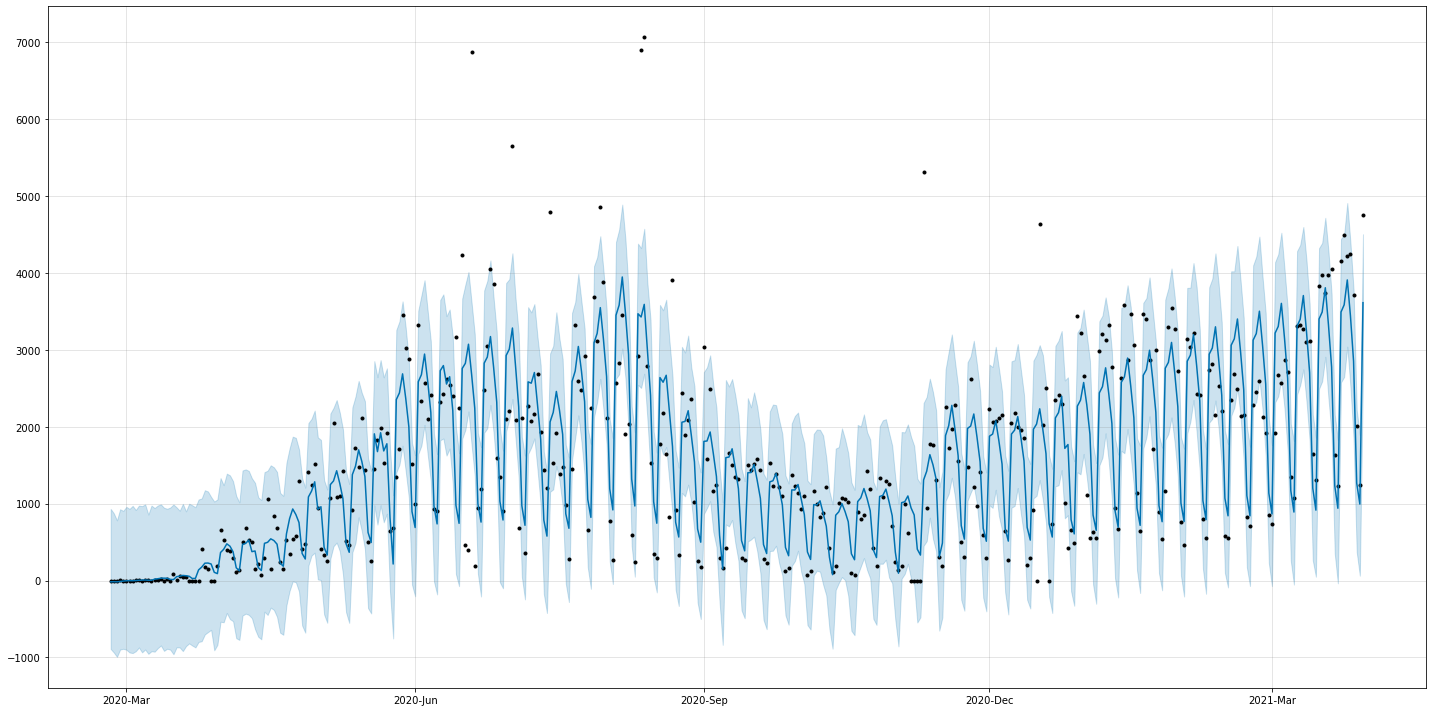

In [69]:
modelo_com_outliers.plota(kwargs_testeplot={'marker':'.', 'color':'red'});

In [70]:
treino = modelo_com_outliers.treino.reset_index()
df_sem_outliers = treino[(treino['y'] > modelo_com_outliers.previsao.yhat_lower[:len(treino)])&(treino['y'] < modelo_com_outliers.previsao.yhat_upper[:len(treino)])]
df_sem_outliers

,index,ds,y
0,0,2020-02-25,0
1,1,2020-02-26,0
2,2,2020-02-27,0
3,3,2020-02-28,1
4,4,2020-02-29,0
...,...,...,...
394,394,2021-03-25,4214
395,395,2021-03-26,4241
396,396,2021-03-27,3709
397,397,2021-03-28,2010


In [72]:
modelo_sem_outliers = Modelo_prophet_semanal(df_sem_outliers, teste_periodo = 0, changepoint_prior_scale=10, seasonality_mode='multiplicative', holidays=feriados,)

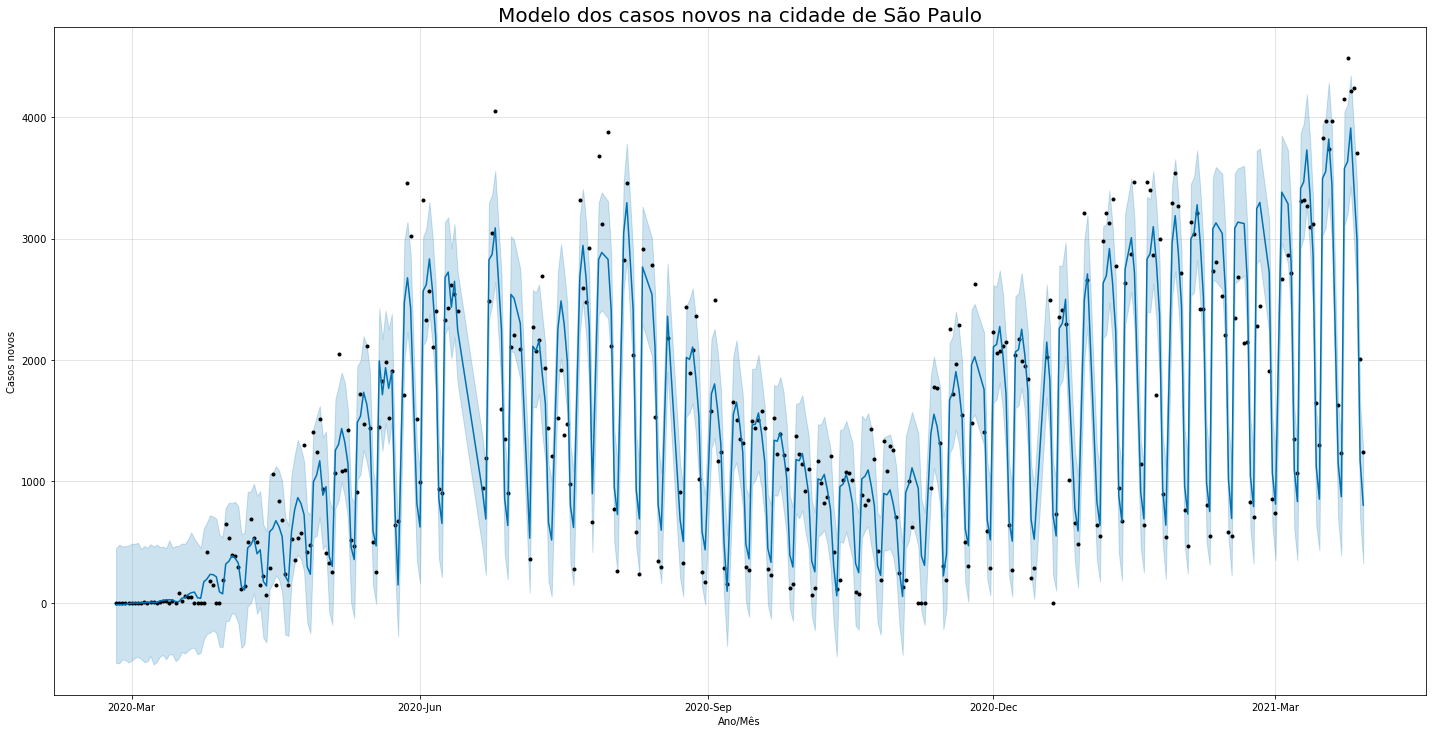

In [73]:
modelo_sem_outliers.plota(xlabel='Ano/Mês', ylabel='Casos novos', kwargs_testeplot={'marker':'.', 'color':'red'})
plt.title('Modelo dos casos novos na cidade de São Paulo', fontsize=20)
plt.show()

## Desafio 13: Testar diferentes intervalos de confiança.

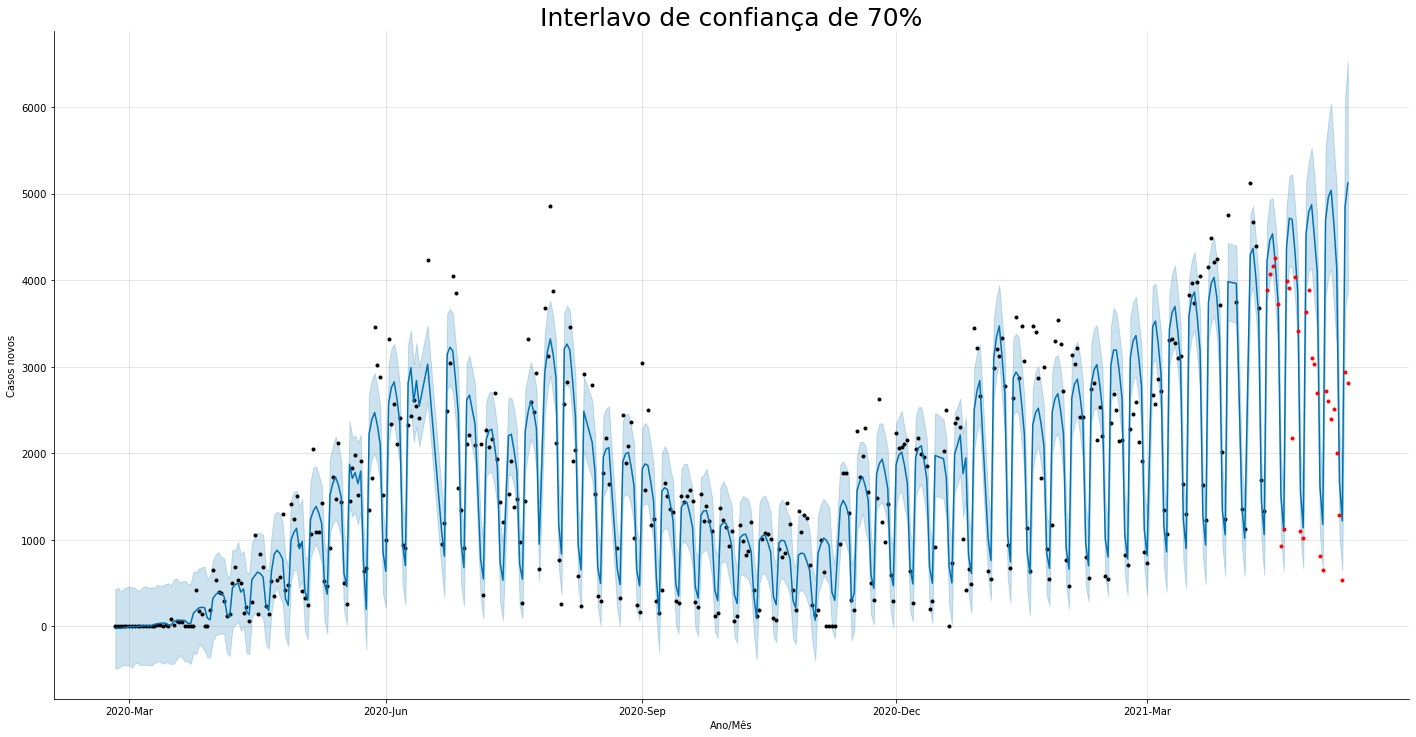

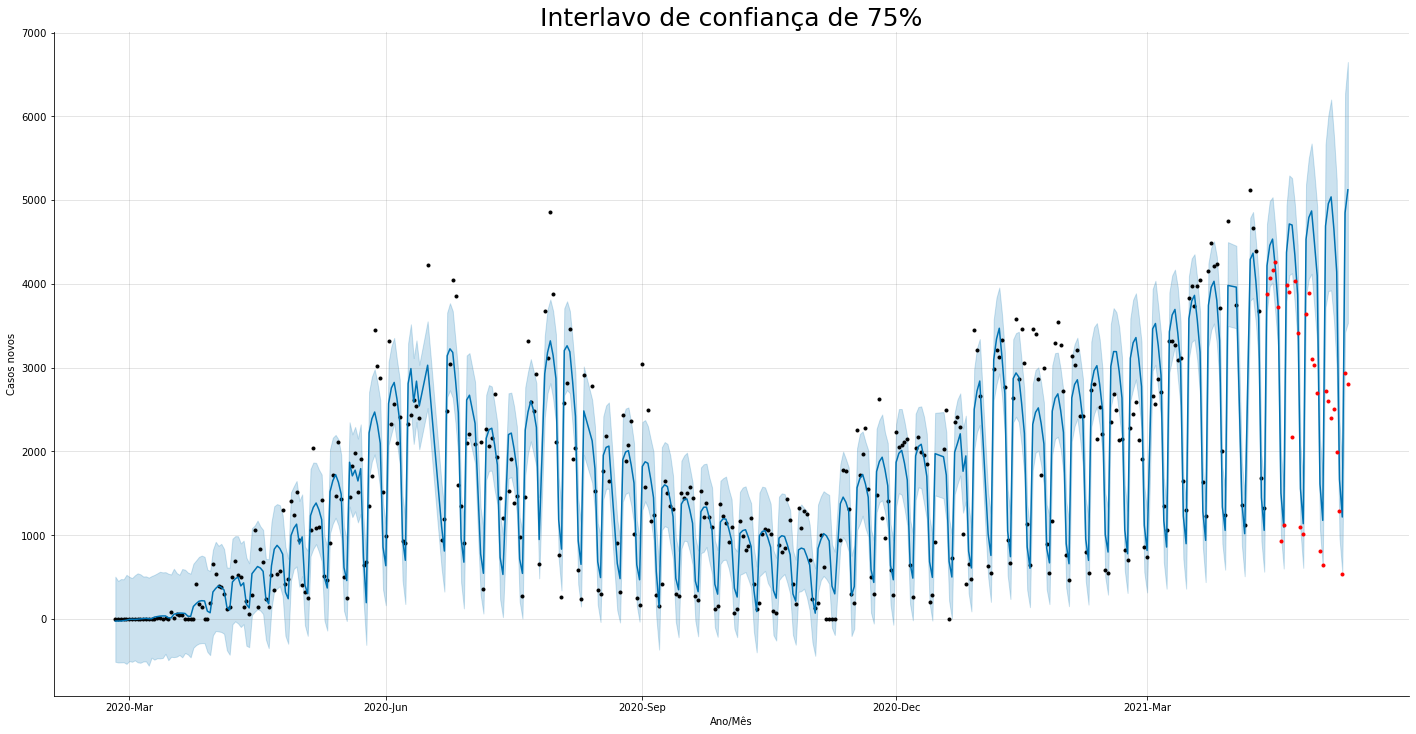

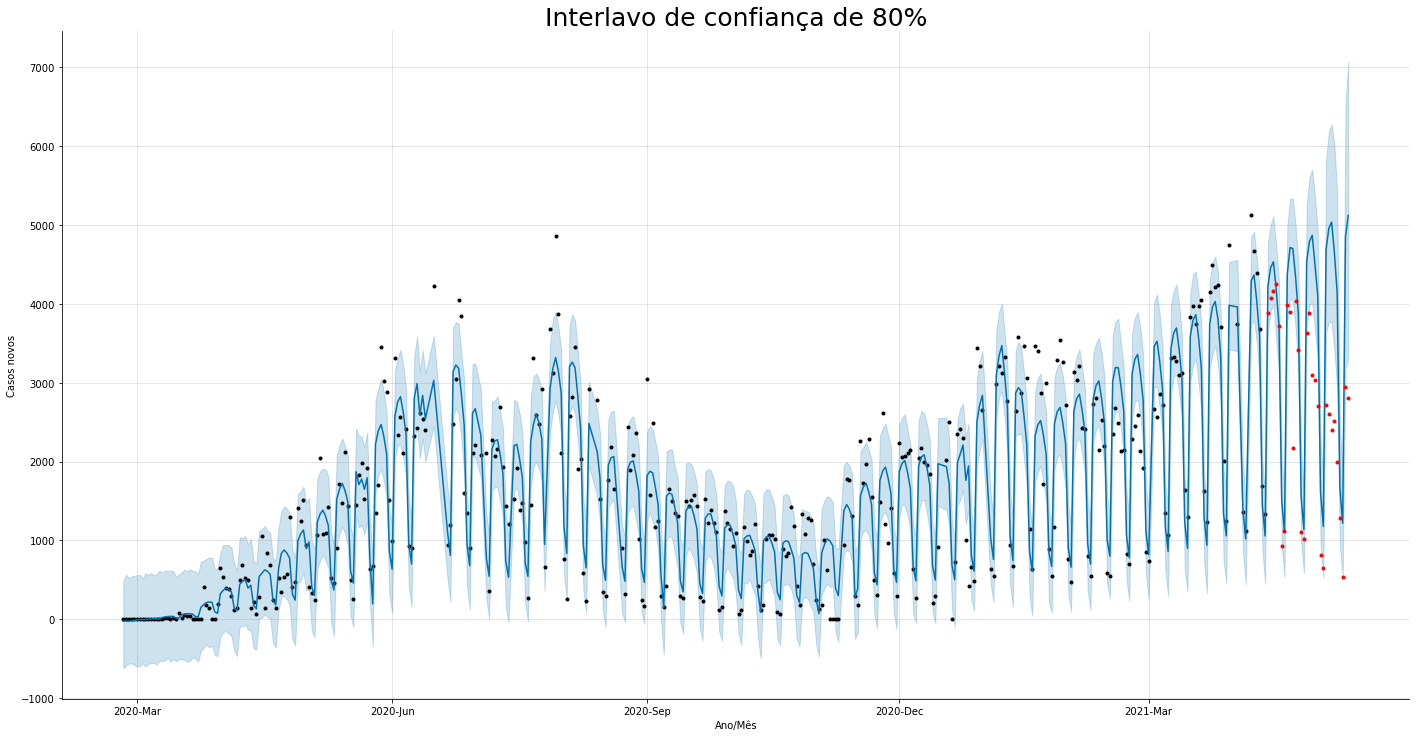

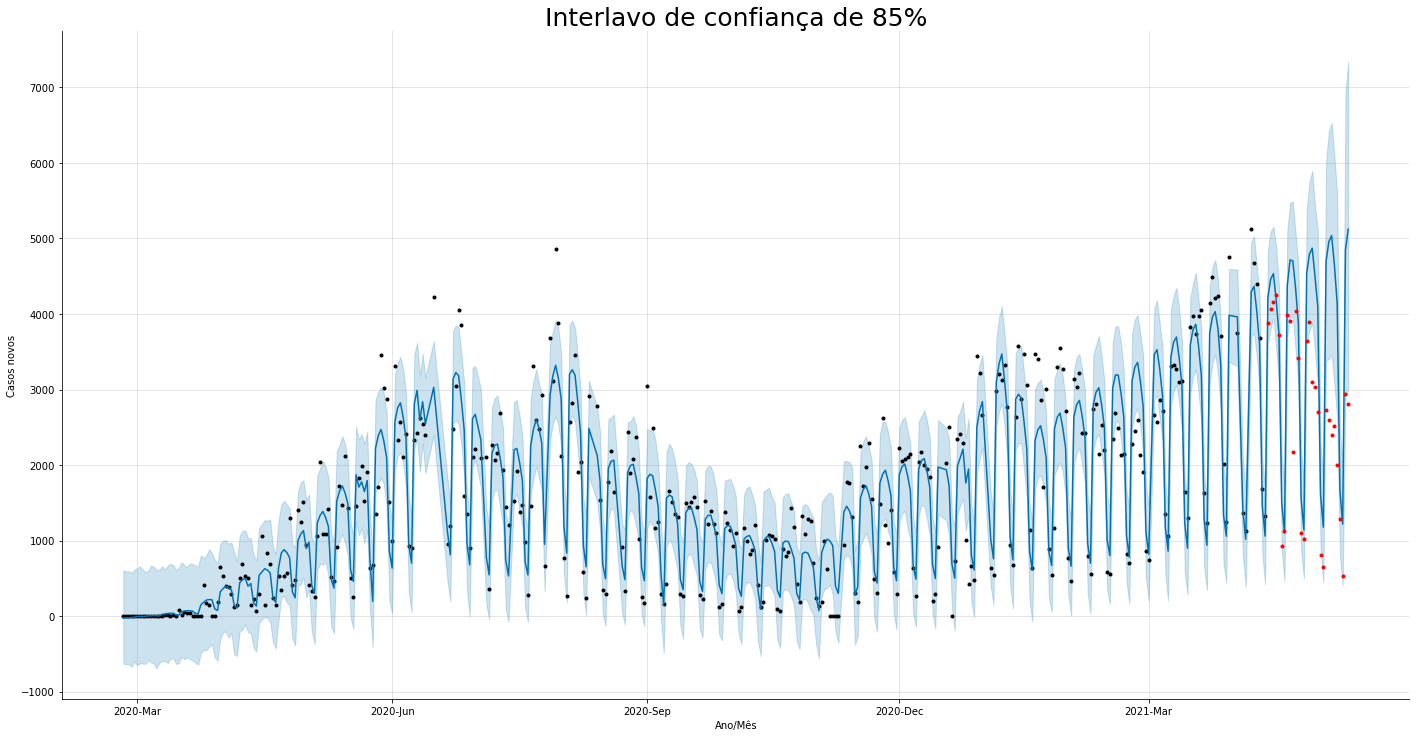

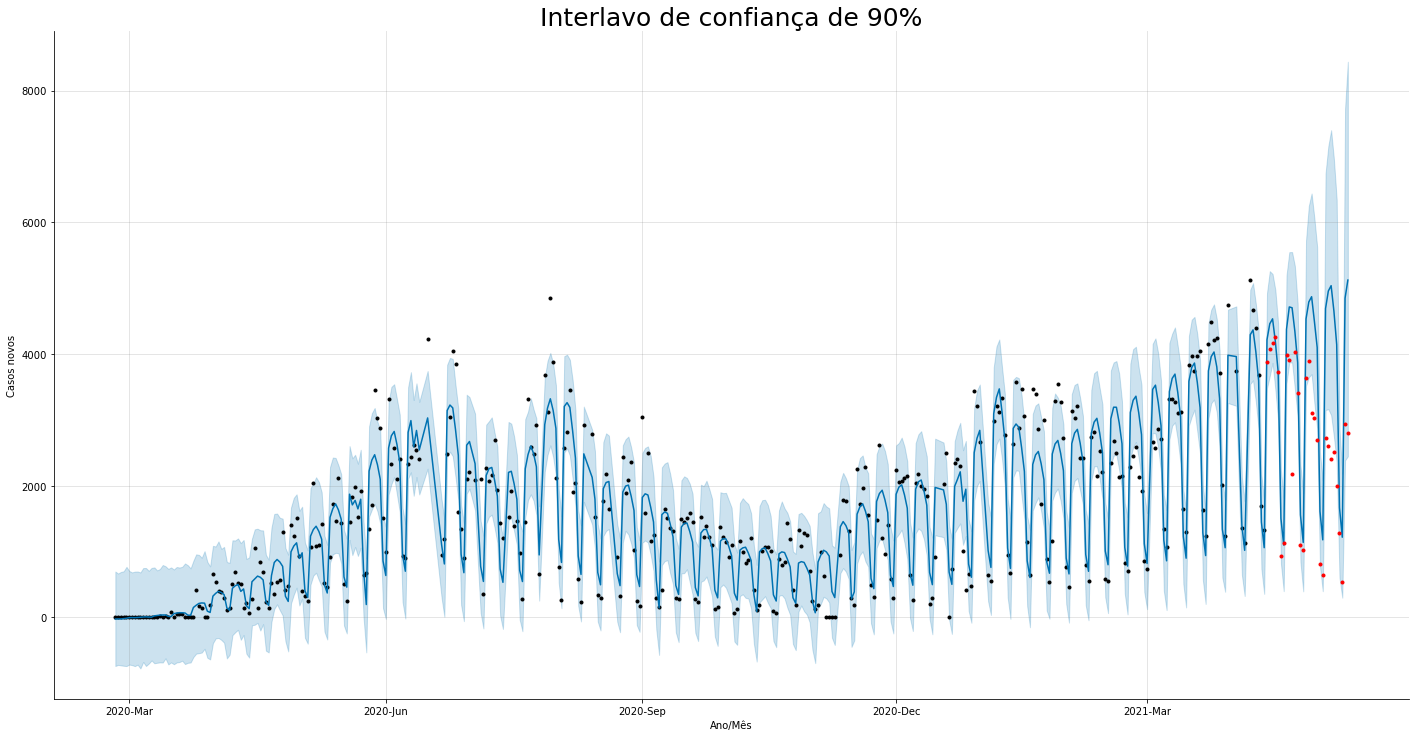

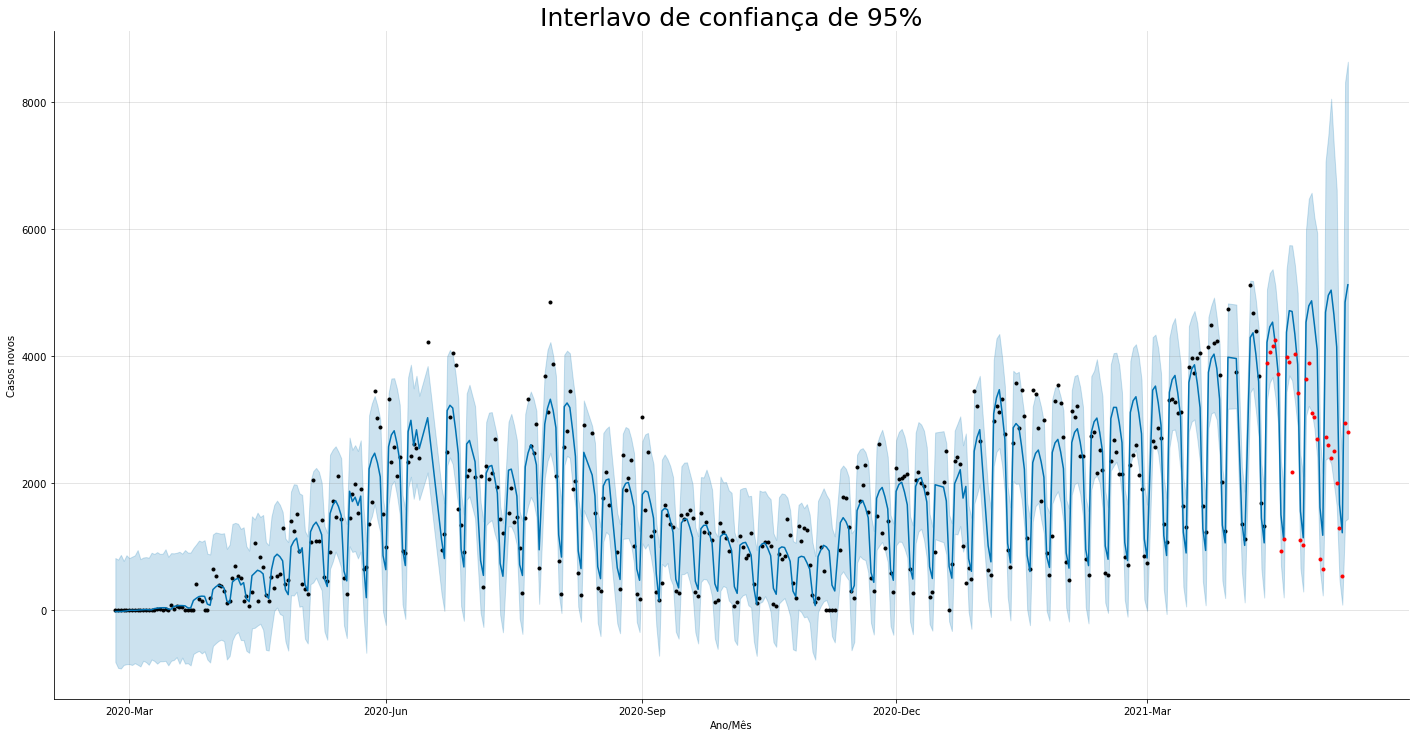

In [8]:
modelos = {}
for i in range(70, 100, 5):
    modelos[str(i)] = Modelo_prophet_semanal(df_sem_outliers.append(modelo_com_outliers.teste), changepoint_prior_scale=10, seasonality_mode='multiplicative', holidays=feriados, interval_width=i/100)
    fig = modelos[str(i)].plota(xlabel='Ano/Mês', ylabel='Casos novos', kwargs_testeplot={'marker':'.', 'color':'red'})
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(f'Interlavo de confiança de {i}%', fontsize=25)

## Desafio 14: Buscar quais métricas se aplicam a quais casos.

Para o caso em questão as métricas utilizadas devem ser aquelas específicas para regressões, pois o papel do modelo é prever um número futuro com base nos dados passados. Partindo dessas informações temos diversas métricas que podemos analisar, alguma delas são:

* MSE - é a média do erro ao quadrado, é realizada calculando a diferença do valor real pelo valor previsto, elevando ao quadrado e realizando a média. Essa métrica dá um peso maior para erros maiores por todos os valores serem elevado ao quadrado
* RMSE - é a raiz quadrada da métrica MSE, por esta razão ela fornece um número dentro da mesma unidade dos dados e conseguimos intepretar melhor muitas vezes
* MAE - é a média do erro absoluto, todas as diferenças influenciam bastante no valor, e é uma média menos sensível à valores muito altos, diferente da MSE
* MAPE - é a média do erro absoluto percentual, usada quando saber o erro percentual é importante, porém deve se tomar cuidado se houverem valores iguais a 0 pois dará um valor indeterminado, ou valores com módulo muito baixo, pois dessa forma o erro fica muito sensível e se eleva com uma variação menor.
* MDAPE - é a mediana do erro absoluto percentual, é menos sensível do que a MAPE por que a mediana não é afetada por valores extremos, apenas os valores médios, logo pode ser uma alternativa quando temos uma diferená muito grande nos valores. 

In [74]:
modelo_sem_outliers.cross_validation()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-08-31 00:00:00 and 2021-02-27 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [75]:
performance_metrics(modelo_sem_outliers.cross)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days,65273.874026,255.487522,184.349497,0.089657,0.888889
1,4 days,131321.174326,362.382635,267.492991,0.165889,0.833333
2,5 days,124581.101296,352.960481,264.175734,0.222781,0.880952
3,6 days,140399.658657,374.699424,293.450165,0.183005,0.851852
4,7 days,74087.367182,272.189947,223.928696,0.110405,0.944444
5,8 days,153119.413330,391.304758,321.203533,0.146842,0.730159
6,9 days,139822.299575,373.928201,303.722463,0.188269,0.777778
7,10 days,163424.864260,404.258413,341.508773,0.227314,0.685185
8,11 days,138441.164162,372.076826,318.110744,0.227314,0.777778
9,12 days,134599.921462,366.878620,297.233619,0.169367,0.769841


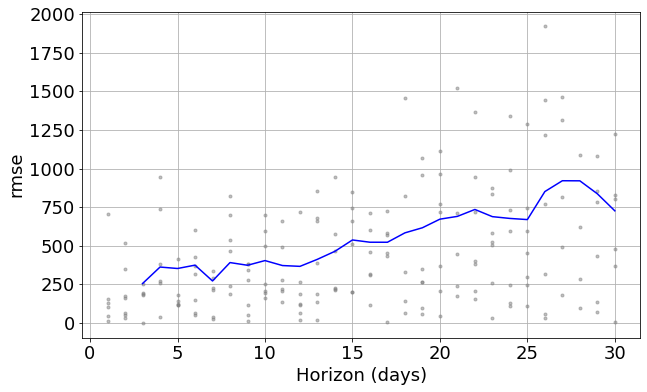

In [80]:
plot_cross_validation_metric(modelo_sem_outliers.cross,metric='rmse');